# Understanding neural_datasets

The purpose of this notebook is to do a "walkthrough" of one of the the brain score datasets, so we can better understand the analysis pipeline. How do we go from "model_identifier" and "benchmark_identifier" to a "brain score"?

In this notebook we'll trace the path for the "'Marques2020_Cavanaugh2002-surround_diameter" benchmark.

# Run the analysis

Our first goal is to reproduce a brainscore that looks like it has a reasonable noise ceiling, since we're going to use computing the noise ceiling to understand the data structure.

Let's try MajajHong2015public.IT-pls with alexnet, where we score .508 on the brainscore website. Running this here, the score we get is 0.50480012. We're going to take that as "close enough".

In [12]:
# %load_ext cudf.pandas

In [1]:
import os
import time
from brainscore_vision import score

/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [2]:
from brainscore_vision.benchmarks.majajhong2015 import *
from brainscore_vision.benchmarks.majajhong2015.benchmark import load_assembly
from brainscore_vision import benchmark_registry

benchmark_registry

{'MajajHong2015.V4-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.DicarloMajajHong2015V4PLS()>,
 'MajajHong2015.IT-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.DicarloMajajHong2015ITPLS()>,
 'MajajHong2015public.V4-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.MajajHongV4PublicBenchmark()>,
 'MajajHong2015public.IT-pls': <function brainscore_vision.benchmarks.majajhong2015.benchmark.MajajHongITPublicBenchmark()>,
 'MajajHong2015public.V4-temporal-pls': <function brainscore_vision.benchmarks.majajhong2015.<lambda>()>,
 'MajajHong2015public.IT-temporal-pls': <function brainscore_vision.benchmarks.majajhong2015.<lambda>()>}

In [3]:
start_time = time.time()
model_identifier = 'alexnet'
benchmark_identifier = f'MajajHong2015public.IT-pls'

similarity_score = score(model_identifier=model_identifier, benchmark_identifier=benchmark_identifier)
end_time = time.time()
dur_min = (end_time - start_time) / 60
print(f"Duration in min = {dur_min:3.2f}")
similarity_score

Defaulting to user installation because normal site-packages is not writeable


/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


cross-validation:  70%|███████   | 7/10 [04:04<01:44, 34.84s/it]

KeyboardInterrupt: 

# explore the dataset

In [ ]:
import numpy as np
import pandas as pd

from brainscore_vision import benchmark_registry
from brainscore_vision import load_metric, Ceiling, load_ceiling, load_dataset
from brainscore_vision.metrics.distribution_similarity import NeuronalPropertyCeiling
from brainscore_core.metrics import Metric, Score
from brainscore_vision.metric_helpers import Defaults as XarrayDefaults


In [5]:
ASSEMBLY_NAME = 'MajajHong2015.public'
assembly = load_dataset(ASSEMBLY_NAME)
assembly

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (neuroid: 256,
                                                                presentation: 148480,
                                                                time_bin: 1)>
dask.array<open_dataset-027f6ff4c498b94c72f000f20552e29bdicarlo.MajajHong2015.public, shape=(256, 148480, 1), dtype=float32, chunksize=(256, 148480, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 18 18 18 18 18 ... 16 16 16 17 17 17
  - stimulus         (presentation) int64 0 426 427 428 429 ... 2569 2566 0 1 2
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 418 419 420 421 ... 3197 641 642 643
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 ... 1.246 1.296 0.9114
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... 0.02724 -10.4
  - tz               (presentation) float64 0.0 0.0 0.0 ... -0.269 -0.599 0.211
  - category_name    (presentation) object 'Cars' 'Faces' ... 'Fruits' 'Fruits'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  - ty               (presentation) float64 0.0 0.0 0.0 ... -0.191 -0.213 0.277
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - object_name      (presentation) object 'car_astra' 'face0' ... 'apple'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 -0.0 -0.0 ... 0.02724 -10.4
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - rxz              (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  * time_bin         (time_bin) MultiIndex
  - time_bin_start   (time_bin) int64 70
  - time_bin_end     (time_bin) int64 170
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [6]:
ceiler = load_ceiling('internal_consistency')
ceiler

Defaulting to user installation because normal site-packages is not writeable


In [7]:
region = "IT"
access = "public"
time_interval = None
assembly_repetition = load_assembly(average_repetitions=False, 
                                    region=region, 
                                    access=access, time_interval=time_interval)

In [8]:
assembly_repetition

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (
                                                                presentation: 148480,
                                                                neuroid: 168)>
array([[ 0.06092933, -0.72559214,  0.42031842, ..., -0.18637353,
         0.28050217,  0.30726328],
       [-0.8479065 ,  0.89549875,  0.9519652 , ..., -2.260826  ,
        -1.1872205 ,  0.35321778],
       [-1.618728  , -0.7792393 , -1.3977592 , ...,  0.22751288,
        -0.17249185,  0.10181567],
       ...,
       [-0.83211136, -1.5217171 ,  1.1938343 , ...,  0.6354223 ,
         0.42337415, -2.2552547 ],
       [-0.83211136, -1.158598  , -0.17778037, ..., -1.6090839 ,
         0.0775381 ,  1.0052351 ],
       [-0.83211136, -0.7954789 , -0.8635877 , ...,  0.6354223 ,
        -0.614134  , -0.2989609 ]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 18 18 18 18 18 ... 16 16 16 17 17 17
  - stimulus         (presentation) int64 0 426 427 428 429 ... 2569 2566 0 1 2
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 418 419 420 421 ... 3197 641 642 643
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 ... 1.246 1.296 0.9114
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... 0.02724 -10.4
  - tz               (presentation) float64 0.0 0.0 0.0 ... -0.269 -0.599 0.211
  - category_name    (presentation) object 'Cars' 'Faces' ... 'Fruits' 'Fruits'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  - ty               (presentation) float64 0.0 0.0 0.0 ... -0.191 -0.213 0.277
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - object_name      (presentation) object 'car_astra' 'face0' ... 'apple'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 -0.0 -0.0 ... 0.02724 -10.4
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - rxz              (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
    time_bin         object (70, 170)
    region           (neuroid) <U2 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [9]:
repetition_dims = assembly_repetition['repetition'].dims
repetition_dims

('presentation',)

In [10]:
from brainio.assemblies import walk_coords, DataAssembly

nonrepetition_coords = [coord for coord, dims, values in walk_coords(assembly_repetition)
                                    if dims == repetition_dims and coord != 'repetition']
nonrepetition_coords

['image_id',
 'stimulus',
 'stimulus_id',
 'id',
 'background_id',
 's',
 'image_file_name',
 'filename',
 'rxy',
 'tz',
 'category_name',
 'rxz_semantic',
 'ty',
 'ryz',
 'object_name',
 'variation',
 'size',
 'rxy_semantic',
 'ryz_semantic',
 'rxz']

In [11]:
average = assembly_repetition.multi_groupby(nonrepetition_coords).mean(dim=repetition_dims)
average

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (
                                                                presentation: 3200,
                                                                neuroid: 168)>
array([[ 0.08579675, -0.40017223, -0.48299602, ...,  0.44299307,
         0.23595507,  0.00478193],
       [ 0.1961998 ,  0.10559011,  0.4308994 , ...,  0.25456306,
        -0.10369828,  0.40033734],
       [ 0.01543091, -0.5408685 , -0.32352096, ...,  0.27328926,
         0.24315262, -0.05489631],
       ...,
       [ 0.3541822 ,  0.29962146,  0.6635341 , ...,  0.3615814 ,
         0.31918818,  0.27234784],
       [ 0.11517322, -0.01251979, -0.55534226, ...,  0.2850026 ,
         0.34246004,  0.15940946],
       [-0.25128886, -0.22716913, -0.40659687, ..., -0.01127249,
        -0.24650788, -0.16409135]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
    time_bin         object (70, 170)
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '0015b49a190e9bce70b108b28dc1a0674...
  - stimulus         (presentation) int64 212 161 1734 1634 ... 990 253 1818 323
  - stimulus_id      (presentation) object '0015b49a190e9bce70b108b28dc1a0674...
  - id               (presentation) int64 210 802 2367 2268 ... 894 2451 964
  - background_id    (presentation) object '561c84a23fcc11df50a1c441a23d19cb4...
  - s                (presentation) float64 1.0 1.133 0.9617 ... 0.916 0.7786
  - image_file_name  (presentation) object 'DTUG_L_rx+00.000_ry+00.000_rz+00....
  - filename         (presentation) object 'DTUG_L_rx+00.000_ry+00.000_rz+00....
  - rxy              (presentation) float64 -0.0 19.93 -41.9 ... 35.54 -34.78
  - tz               (presentation) float64 0.0 0.009 0.549 ... 0.297 0.485
  - category_name    (presentation) object 'Boats' 'Animals' ... 'Cars' 'Tables'
  - rxz_semantic     (presentation) float64 0.0 43.35 13.67 ... 36.42 -8.024
  - ty               (presentation) float64 0.0 0.068 -0.263 ... -0.12 0.173
  - ryz              (presentation) float64 -0.0 38.46 23.85 ... 6.701 -25.66
  - object_name      (presentation) object 'ship2' 'bear' ... 'table0'
  - variation        (presentation) int64 0 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 109.9 -131.9 ... 125.5 -34.78
  - ryz_semantic     (presentation) float64 -0.0 38.46 23.85 ... 6.701 -25.66
  - rxz              (presentation) float64 0.0 43.35 13.67 ... 36.42 -8.024

In [12]:
average.shape

(3200, 168)

In [13]:

XarrayDefaults.stimulus_coord, XarrayDefaults.neuroid_coord

('stimulus_id', 'neuroid_id')

In [14]:
# ceiling should be: array(0.81579938)
ceiling = ceiler(assembly_repetition)
ceiling

cross-validation: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


<xarray.DataArray ()>
array(0.81579938)
Attributes:
    raw:      <xarray.DataArray (split: 10, neuroid: 168)>\narray([[0.1951266...
    error:    <xarray.DataArray ()>\narray(0.00144955)

In [15]:
ceiling.values.shape, np.nanmean(ceiling.values)

((), 0.8157993788025764)

In [16]:
np.nanmedian(ceiling.raw, axis=1).mean()

0.8157993788025764

# Manually compute the noise ceiling

OK, here's how they compute the noise ceiling for MajajHong2015.public:
-  split the data into 2 halves 
- compute the pearson correlation between half1, half2 
- use spearman brown adjustment to estimate reliability of the full dataset
- repeat 10 times
- take the median across neural sites
- take the mean across iterations

So let's reproduce these steps using their code, which is intensiely wrapped up, and frustratingly difficult to track. But, but stepping through it, we can unpack it into the critical bits, then re-implement it using functions. functional programming >> object-based-obfuscation. 

We want to be able to compute the noise ceiling like this:

```
ceiling = compute_noise_ceiling_split_halves(raw_data, num_splits=10, ...)
ceiling
```
And then when you step through the noise_ceiling function, just a single function, you can see EXACTLY how the analysis is carried out.

BUT FIRST....let's use their primatives.

In [4]:
# load a subset of the data
region = "IT"
access = "public"
time_interval = None
assembly_repetition = load_assembly(average_repetitions=False, 
                                    region=region, 
                                    access=access, time_interval=time_interval)

# Looks like 148480 trials acros 168 neural sites
assembly_repetition.shape

(148480, 168)

In [15]:
import scipy
import numpy as np 
import pandas as pd

from brainscore_core.metrics import Metric, Score
from brainio.assemblies import walk_coords, DataAssembly
from brainscore_vision.metric_helpers.xarray_utils import XarrayCorrelation

from brainscore_vision.metrics.internal_consistency.ceiling import (
    _SplitHalvesConsistency, SpearmanBrownCorrection, PearsonCorrelation, XarrayDefaults, CrossValidationSingle
)

class PearsonCorrelation:
    """
    Computes the Pearson r between two halves of an assembly.
    """

    def __init__(self, stimulus_coord=XarrayDefaults.stimulus_coord,
                 neuroid_dim=XarrayDefaults.neuroid_dim, neuroid_coord=XarrayDefaults.neuroid_coord):
        correlation = scipy.stats.pearsonr
        self._correlation = XarrayCorrelation(correlation, correlation_coord=stimulus_coord,
                                              neuroid_coord=neuroid_coord)
        self._neuroid_dim = neuroid_dim

    def __call__(self, half1, half2):
        return self._correlation(half1, half2)

    def aggregate(self, scores):
        return scores.median(dim=self._neuroid_dim)
    
class SplitHalfWrapper:
        def __init__(self, split_coord, consistency_metric: Metric, correction):
            self._split_coord = split_coord
            self._consistency_metric = consistency_metric
            self._correction = correction

        def __call__(self, half1, half2):
            half1, half2 = self._average_repetitions(half1), self._average_repetitions(half2)
            consistency = self._consistency_metric(half1, half2)
            corrected_consistency = self._correction(consistency, n=2)
            return corrected_consistency

        def _average_repetitions(self, assembly):
            repetition_dims = assembly[self._split_coord].dims
            nonrepetition_coords = [coord for coord, dims, values in walk_coords(assembly)
                                    if dims == repetition_dims and coord != self._split_coord]
            average = assembly.multi_groupby(nonrepetition_coords).mean(dim=repetition_dims)
            return average
        
def _average_repetitions(assembly, split_coord):
    repetition_dims = assembly[split_coord].dims
    nonrepetition_coords = [coord for coord, dims, values in walk_coords(assembly)
                            if dims == repetition_dims and coord != split_coord]
    average = assembly.multi_groupby(nonrepetition_coords).mean(dim=repetition_dims)
    return average        

In [7]:
from scipy.stats import pearsonr

def xarray_correlation(prediction, target, neuroid_coord, correlation_coord, _correlation=pearsonr):
    # align
    prediction = prediction.sortby([correlation_coord, neuroid_coord])
    target = target.sortby([correlation_coord, neuroid_coord])
    
    # Assert alignment
    assert np.array(prediction[correlation_coord].values == target[correlation_coord].values).all()
    assert np.array(prediction[neuroid_coord].values == target[neuroid_coord].values).all()

    # Compute correlation per neuroid
    neuroid_dims = target[neuroid_coord].dims
    assert len(neuroid_dims) == 1
    correlations = []
    
    for i, coord_value in enumerate(target[neuroid_coord].values):
        target_neuroids = target.isel(**{neuroid_dims[0]: i})  # `isel` is about 10x faster than `sel`
        prediction_neuroids = prediction.isel(**{neuroid_dims[0]: i})
        r, p = _correlation(target_neuroids, prediction_neuroids)
        correlations.append(r)

    # Package the result
    result = Score(correlations,
                   coords={coord: (dims, values)
                           for coord, dims, values in walk_coords(target) if dims == neuroid_dims},
                   dims=neuroid_dims)
    
    return result

In [8]:
# XarrayDefaults.neuroid_coord

In [9]:
split_coord='repetition'
stimulus_coord = 'stimulus_id'
neuroid_dim = 'neuroid'
neuroid_coord = 'neuroid_id'
cross_validation_kwargs=None

consistency_metric = PearsonCorrelation(stimulus_coord=stimulus_coord, 
                                        neuroid_dim=neuroid_dim,
                                        neuroid_coord=neuroid_coord)
aggregate = consistency_metric.aggregate
    
correction = SpearmanBrownCorrection()
_consistency = SplitHalfWrapper(split_coord=split_coord,
                                consistency_metric=consistency_metric, correction=correction)
_aggregate = aggregate
cross_validation_defaults = dict(train_size=0.5, split_coord=split_coord,
                                 stratification_coord=None, unique_split_values=True)
cross_validation_kwargs = {**cross_validation_defaults, **(cross_validation_kwargs or {})}
_cross_validation = CrossValidationSingle(**cross_validation_kwargs)

In [10]:
cross_validation_kwargs

{'train_size': 0.5,
 'split_coord': 'repetition',
 'stratification_coord': None,
 'unique_split_values': True}

In [11]:
result = _cross_validation(assembly_repetition, apply=_consistency, aggregate=_aggregate)
result


cross-validation:  70%|███████   | 7/10 [05:04<02:10, 43.47s/it]

cross-validation: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


<xarray.DataArray ()>
array(0.81579938)
Attributes:
    raw:      <xarray.DataArray (split: 10, neuroid: 168)>\narray([[0.1951266...
    error:    <xarray.DataArray ()>\narray(0.00144955)

In [12]:
# let's manually step through the CrossValidationSingle step
cross_validation_values, splits = _cross_validation._split.build_splits(assembly_repetition)
cross_validation_values.shape, splits

((51,),
 [(array([ 4, 34, 14, 31, 10, 28, 45, 35, 18, 20, 25,  6,  7, 48,  1, 16,  0,
          15,  5, 11,  9,  8, 12, 43, 37]),
   array([22,  2, 49, 26, 33, 44, 30, 50, 32, 27,  3, 29, 47, 41, 39, 21, 40,
          38, 19, 24, 13, 42, 17, 46, 36, 23])),
  (array([ 5, 27, 40, 37, 36,  3,  9, 22, 39, 47,  7, 23, 34, 25,  4,  0, 15,
          18, 41, 45, 16, 26, 12, 43, 49]),
   array([29, 20, 32, 28, 14, 17, 35, 11,  1, 13, 46, 33, 21, 24, 48, 31, 30,
          50, 42, 10,  2, 44,  8,  6, 19, 38])),
  (array([35, 17, 28, 23, 10, 41, 32, 18,  4, 42, 30, 20, 46, 43,  8, 13,  7,
          11, 49, 27, 12,  2, 50, 21,  6]),
   array([34,  3, 45,  5, 33, 40, 31, 39, 14, 44, 48, 29, 16, 26, 15, 22, 47,
          19,  9,  1, 38,  0, 37, 36, 24, 25])),
  (array([ 9, 30, 15, 27, 24, 34,  6, 43, 45, 14, 40, 19, 41, 21, 25, 32, 10,
          49, 33, 13, 37, 22, 48, 20, 42]),
   array([44, 12,  1, 35, 26, 11, 38, 36, 23,  3, 50,  0, 29, 16, 46, 18, 28,
          17, 31,  8, 47,  4,  5, 39,  7,  2]

In [13]:
print(len(splits))
print(splits[0])
print(splits[1])

10
(array([ 4, 34, 14, 31, 10, 28, 45, 35, 18, 20, 25,  6,  7, 48,  1, 16,  0,
       15,  5, 11,  9,  8, 12, 43, 37]), array([22,  2, 49, 26, 33, 44, 30, 50, 32, 27,  3, 29, 47, 41, 39, 21, 40,
       38, 19, 24, 13, 42, 17, 46, 36, 23]))
(array([ 5, 27, 40, 37, 36,  3,  9, 22, 39, 47,  7, 23, 34, 25,  4,  0, 15,
       18, 41, 45, 16, 26, 12, 43, 49]), array([29, 20, 32, 28, 14, 17, 35, 11,  1, 13, 46, 33, 21, 24, 48, 31, 30,
       50, 42, 10,  2, 44,  8,  6, 19, 38]))


In [16]:
np.unique(assembly_repetition.repetition.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [90]:
from tqdm import tqdm
from brainio.transform import subset
from brainscore_vision.benchmark_helpers.neural_common import average_repetition
from brainscore_vision.metrics import Score
from scipy.stats import pearsonr

assembly = assembly_repetition
split_scores = []
for split_iterator, (train_indices, test_indices) \
        in tqdm(enumerate(splits), total=len(splits), desc='cross-validation'):
    train_values, test_values = cross_validation_values[train_indices], cross_validation_values[test_indices]
    train = subset(assembly, train_values, dims_must_match=False)
    #train_mask = np.isin(assembly.repetition.values, train_values)
    #train = assembly.values[train_mask,:]

    test = subset(assembly, test_values, dims_must_match=False)
    #test_mask = np.isin(assembly.repetition.values, test_values)
    #test = assembly.values[test_mask,:]
        
    split_score = _consistency(train, test)
    # half1 = _average_repetitions(train, split_coord)
    # half2 = _average_repetitions(test, split_coord)
    
    split_score = split_score.expand_dims('split')
    split_score['split'] = [split_iterator]
    split_scores.append(split_score)
split_scores = Score.merge(*split_scores)

cross-validation: 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


In [91]:
split_coord

'repetition'

In [92]:
split_score = _consistency(train, test)
split_score

<xarray.DataArray (neuroid: 168)>
array([0.19640871, 0.6832725 , 0.70856556, 0.19225809, 0.41102693,
       0.56731674, 0.74688394, 0.77980418, 0.78578487, 0.22858195,
       0.71219449, 0.55830477, 0.71737657, 0.15785864, 0.56759389,
       0.87373494, 0.80562444, 0.55634716, 0.63783409, 0.50080861,
       0.55081959, 0.7354928 , 0.95904232, 0.96557711, 0.81103736,
       0.82357803, 0.68699964, 0.65717807, 0.91779244, 0.88480388,
       0.94410992, 0.93450658, 0.94827766, 0.56067151, 0.52672755,
       0.92568181, 0.95851747, 0.96679437, 0.97151962, 0.90743301,
       0.4482424 , 0.67625339, 0.08802038, 0.88527528, 0.72770343,
       0.87645347, 0.87133615, 0.92196382, 0.92084523, 0.94337326,
       0.38962194, 0.43909097, 0.9591528 , 0.89483165, 0.9344777 ,
       0.96562716, 0.94940872, 0.9351618 , 0.8606954 , 0.7626334 ,
       0.687493  , 0.36177628, 0.30745548, 0.41639175, 0.57143819,
       0.48697115, 0.43077356, 0.13899427, 0.7208611 , 0.66562766,
       0.6387165 , 0.57454909, 0.61709131, 0.32922515, 0.79252298,
       0.86510794, 0.74263556, 0.75611145, 0.42578989, 0.35373316,
       0.6951902 , 0.86202197, 0.70664703, 0.26032211, 0.67497532,
       0.84295827, 0.56361642, 0.50041235, 0.81611677, 0.80428382,
       0.46339837, 0.74570234, 0.63301417, 0.60182585, 0.65296118,
       0.56723697, 0.83857458, 0.6108672 , 0.93989124, 0.93116961,
       0.83194856, 0.61277975, 0.93233631, 0.83134279, 0.83033925,
       0.8557232 , 0.80959552, 0.75483391, 0.5266757 , 0.93962591,
       0.74877323, 0.88995023, 0.8054028 , 0.82676588, 0.74377552,
       0.76380812, 0.91206061, 0.86365139, 0.75163372, 0.73433275,
       0.78807378, 0.85531757, 0.76537115, 0.89228725, 0.81812296,
       0.88220244, 0.82097346, 0.88793009, 0.84965231, 0.9041042 ,
       0.85429785, 0.91576976, 0.84812911, 0.76859113, 0.81124572,
       0.90893257, 0.87185566, 0.90213676, 0.95069625, 0.90224154,
       0.94753982, 0.88158037, 0.94720761, 0.84116251, 0.9289257 ,
       0.82820044, 0.73587899, 0.84223109, 0.90287371, 0.88222886,
       0.89602086, 0.91369717, 0.70916548, 0.85774853, 0.8942807 ,
       0.72799895, 0.86521631, 0.86886844, 0.80194384, 0.79894429,
       0.82849842, 0.84813951, 0.64646835, 0.85431684, 0.87517944,
       0.88817281, 0.82258442, 0.84959486])
Coordinates:
  * neuroid     (neuroid) MultiIndex
  - neuroid_id  (neuroid) object 'Chabo_L_A_2_4' ... 'Tito_L_M_9_8'
  - arr         (neuroid) object 'A' 'A' 'A' 'A' 'A' 'A' ... 'M' 'M' 'M' 'M' 'M'
  - col         (neuroid) int64 4 3 5 0 1 2 3 4 5 6 2 ... 4 5 6 7 8 1 3 4 5 7 8
  - hemisphere  (neuroid) object 'L' 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion   (neuroid) object 'cIT' 'cIT' 'aIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal      (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y           (neuroid) float64 -1.0 -0.6 -0.6 -0.2 -0.2 ... 1.8 1.8 1.8 1.8
  - x           (neuroid) float64 -0.2 -0.6 0.2 -1.8 -1.4 ... -0.2 0.2 1.0 1.4
  - row         (neuroid) int64 2 3 3 4 4 4 4 4 4 4 5 ... 8 8 8 8 8 9 9 9 9 9 9
  - region      (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'

In [93]:
split_scores.shape, np.nanmedian(split_scores)

((10, 168), 0.8168780899381866)

In [94]:
np.nanmedian(split_scores, axis=1)

array([0.80693763, 0.81848463, 0.82195214, 0.81398179, 0.81686678,
       0.82128241, 0.81449916, 0.81984574, 0.81382706, 0.81031644])

In [95]:
np.nanmedian(split_scores, axis=1).mean()

0.8157993788025764

In [96]:
# np.median(split_score)

In [97]:
all_values = assembly.values
all_values.shape

(148480, 168)

In [98]:
# Create a boolean mask
train_mask = np.isin(assembly.repetition.values, train_values)
train_data = assembly.values[train_mask,:]
train_data.shape, train.shape

((76160, 168), (76160, 168))

In [99]:
half1 = _average_repetitions(train, split_coord)
half2 = _average_repetitions(test, split_coord)

In [100]:
consistency = consistency_metric(half1, half2)
corrected_consistency = correction(consistency, n=2)
np.nanmedian(corrected_consistency)

0.8103164373997906

In [101]:
correlation = scipy.stats.pearsonr
_correlation = XarrayCorrelation(correlation, correlation_coord=stimulus_coord,
                                 neuroid_coord=neuroid_coord)
consistency = _correlation(half1, half2)
corrected_consistency = correction(consistency, n=2)
np.nanmedian(corrected_consistency)

0.8103164373997906

In [102]:
consistency_scores = xarray_correlation(half1, half2, neuroid_coord=neuroid_coord, correlation_coord=stimulus_coord)
corrected_consistency = correction(consistency_scores, n=2)
np.nanmedian(corrected_consistency)

0.8103164373997906

In [103]:
correlation_coord=stimulus_coord
[correlation_coord, neuroid_coord]

['stimulus_id', 'neuroid_id']

In [112]:
import time
from tqdm import tqdm 

start = time.time()
_correlation=pearsonr

prediction = half1.sortby([correlation_coord, neuroid_coord])
target = half2.sortby([correlation_coord, neuroid_coord])

# Assert alignment
assert np.array(prediction[correlation_coord].values == target[correlation_coord].values).all()
assert np.array(prediction[neuroid_coord].values == target[neuroid_coord].values).all()

# Compute correlation per neuroid
neuroid_dims = target[neuroid_coord].dims
assert len(neuroid_dims) == 1
correlations = []

for i, coord_value in enumerate(tqdm(target[neuroid_coord].values)):
    target_neuroids = target.isel(**{neuroid_dims[0]: i})  # `isel` is about 10x faster than `sel`
    prediction_neuroids = prediction.isel(**{neuroid_dims[0]: i})
    r, p = _correlation(target_neuroids, prediction_neuroids)
    correlations.append(r)
corrected_consistency = correction(np.array(correlations), n=2)
np.nanmedian(corrected_consistency), time.time() - start

100%|██████████| 168/168 [00:00<00:00, 571.66it/s]


(0.8103164373997906, 0.3122560977935791)

In [ ]:
# 0.8103164430067702

In [ ]:
i, neuroid_dims[0], {neuroid_dims[0]: i}

In [ ]:
target.shape

In [ ]:
target_neuroids1 = target.isel(**{neuroid_dims[0]: i})
target_neuroids1.shape

In [ ]:
target_neuroids2 = target.isel({'neuroid': 167})
target_neuroids2.shape

In [ ]:
all(target_neuroids1.values == target_neuroids2.values)

In [ ]:
print("ready")

In [38]:
train_df = train.to_dataframe(name='values').reset_index()
train_df

,image_id,repetition,stimulus,stimulus_id,id,background_id,s,image_file_name,filename,rxy,...,col,hemisphere,subregion,animal,y,x,row,time_bin,region,values
0,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,9,L,cIT,Chabo,0.2,1.8,5,"(70, 170)",IT,0.060929
1,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,9,L,cIT,Chabo,0.6,1.8,6,"(70, 170)",IT,-0.725592
2,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,8,L,cIT,Chabo,0.2,1.4,5,"(70, 170)",IT,0.420318
3,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,9,L,cIT,Chabo,1.0,1.8,7,"(70, 170)",IT,0.640482
4,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,8,L,cIT,Chabo,0.6,1.4,6,"(70, 170)",IT,-1.247330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12794875,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,0,L,pIT,Tito,0.6,-1.8,6,"(70, 170)",IT,-0.692045
12794876,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,0,L,pIT,Tito,1.0,-1.8,7,"(70, 170)",IT,0.757786
12794877,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,1,L,pIT,Tito,1.0,-1.4,7,"(70, 170)",IT,0.635422
12794878,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,1,L,pIT,Tito,1.8,-1.4,9,"(70, 170)",IT,-0.614134


In [52]:
train_df.iloc[0]

image_id                    8a72e2bfdb8c267b57232bf96f069374d5b21832
repetition                                                         0
stimulus                                                           0
stimulus_id                 8a72e2bfdb8c267b57232bf96f069374d5b21832
id                                                                 1
background_id               ecd40f3f6d7a4d6d88134d648884e0b9b364efc9
s                                                                1.0
image_file_name    astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
filename           astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
rxy                                                             -0.0
tz                                                               0.0
category_name                                                   Cars
rxz_semantic                                                     0.0
ty                                                               0.0
ryz                               

In [63]:
test_df = test.to_dataframe(name='values').reset_index()
test_df

,image_id,repetition,stimulus,stimulus_id,id,background_id,s,image_file_name,filename,rxy,...,col,hemisphere,subregion,animal,y,x,row,time_bin,region,values
0,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,18,426,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,418,a9fc755011e14e4287557c0b8ee3bf860896604a,1.000000,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,...,9,L,cIT,Chabo,0.2,1.8,5,"(70, 170)",IT,-0.847906
1,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,18,426,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,418,a9fc755011e14e4287557c0b8ee3bf860896604a,1.000000,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,...,9,L,cIT,Chabo,0.6,1.8,6,"(70, 170)",IT,0.895499
2,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,18,426,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,418,a9fc755011e14e4287557c0b8ee3bf860896604a,1.000000,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,...,8,L,cIT,Chabo,0.2,1.4,5,"(70, 170)",IT,0.951965
3,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,18,426,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,418,a9fc755011e14e4287557c0b8ee3bf860896604a,1.000000,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,...,9,L,cIT,Chabo,1.0,1.8,7,"(70, 170)",IT,0.991389
4,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,18,426,b531d7dfc461ab0bc9558773135e6cc1ccbe5b5c,418,a9fc755011e14e4287557c0b8ee3bf860896604a,1.000000,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,face0001_rx+00.000_ry+00.000_rz+00.000_tx+00.0...,-0.000000,...,8,L,cIT,Chabo,0.6,1.4,6,"(70, 170)",IT,0.741997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12149755,cd700aaecc22f58087a07a22eb550d52a3af66ba,18,2564,cd700aaecc22f58087a07a22eb550d52a3af66ba,3195,5bcd33f98bb9094101710f12a4d9755e73a19b83,1.294286,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,22.527023,...,0,L,pIT,Tito,0.6,-1.8,6,"(70, 170)",IT,-0.446061
12149756,cd700aaecc22f58087a07a22eb550d52a3af66ba,18,2564,cd700aaecc22f58087a07a22eb550d52a3af66ba,3195,5bcd33f98bb9094101710f12a4d9755e73a19b83,1.294286,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,22.527023,...,0,L,pIT,Tito,1.0,-1.8,7,"(70, 170)",IT,1.159301
12149757,cd700aaecc22f58087a07a22eb550d52a3af66ba,18,2564,cd700aaecc22f58087a07a22eb550d52a3af66ba,3195,5bcd33f98bb9094101710f12a4d9755e73a19b83,1.294286,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,22.527023,...,1,L,pIT,Tito,1.0,-1.4,7,"(70, 170)",IT,-0.392419
12149758,cd700aaecc22f58087a07a22eb550d52a3af66ba,18,2564,cd700aaecc22f58087a07a22eb550d52a3af66ba,3195,5bcd33f98bb9094101710f12a4d9755e73a19b83,1.294286,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,Peach_obj_rx-124.697_ry-36.803_rz+20.712_tx-00...,22.527023,...,1,L,pIT,Tito,1.8,-1.4,9,"(70, 170)",IT,-0.014023


In [66]:
import cudf

train_cdf = train_df # cudf.from_pandas(train_df)
test_cdf = test_df
train_cdf

,image_id,repetition,stimulus,stimulus_id,id,background_id,s,image_file_name,filename,rxy,...,col,hemisphere,subregion,animal,y,x,row,time_bin,region,values
0,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,9,L,cIT,Chabo,0.2,1.8,5,"(70, 170)",IT,0.060929
1,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,9,L,cIT,Chabo,0.6,1.8,6,"(70, 170)",IT,-0.725592
2,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,8,L,cIT,Chabo,0.2,1.4,5,"(70, 170)",IT,0.420318
3,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,9,L,cIT,Chabo,1.0,1.8,7,"(70, 170)",IT,0.640482
4,8a72e2bfdb8c267b57232bf96f069374d5b21832,0,0,8a72e2bfdb8c267b57232bf96f069374d5b21832,1,ecd40f3f6d7a4d6d88134d648884e0b9b364efc9,1.000000,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...,-0.000000,...,8,L,cIT,Chabo,0.6,1.4,6,"(70, 170)",IT,-1.247330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12794875,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,0,L,pIT,Tito,0.6,-1.8,6,"(70, 170)",IT,-0.692045
12794876,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,0,L,pIT,Tito,1.0,-1.8,7,"(70, 170)",IT,0.757786
12794877,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,1,L,pIT,Tito,1.0,-1.4,7,"(70, 170)",IT,0.635422
12794878,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,17,2,6b834433a431c9e59c1cd0f0c3af79aa6093dfcb,643,dd611f4df5e53376da5d45c79a2ea0f886814c09,0.911429,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,Apple_Fruit_obj_rx-107.960_ry+34.497_rz+35.639...,-10.402834,...,1,L,pIT,Tito,1.8,-1.4,9,"(70, 170)",IT,-0.614134


In [67]:
train_cdf.iloc[0]

image_id                    8a72e2bfdb8c267b57232bf96f069374d5b21832
repetition                                                         0
stimulus                                                           0
stimulus_id                 8a72e2bfdb8c267b57232bf96f069374d5b21832
id                                                                 1
background_id               ecd40f3f6d7a4d6d88134d648884e0b9b364efc9
s                                                                1.0
image_file_name    astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
filename           astra_rx+00.000_ry+00.000_rz+00.000_tx+00.000_...
rxy                                                             -0.0
tz                                                               0.0
category_name                                                   Cars
rxz_semantic                                                     0.0
ty                                                               0.0
ryz                               

In [68]:
split_coord

'repetition'

In [54]:
repetition_dims = assembly[split_coord].dims
nonrepetition_coords = [coord for coord, dims, values in walk_coords(assembly)
                        if dims == repetition_dims and coord != split_coord] + ['neuroid_id']
nonrepetition_coords

['image_id',
 'stimulus',
 'stimulus_id',
 'id',
 'background_id',
 's',
 'image_file_name',
 'filename',
 'rxy',
 'tz',
 'category_name',
 'rxz_semantic',
 'ty',
 'ryz',
 'object_name',
 'variation',
 'size',
 'rxy_semantic',
 'ryz_semantic',
 'rxz',
 'neuroid_id']

In [55]:
import time

start = time.time()
train_grp = train_df.groupby(by=nonrepetition_coords)
# Apply mean to numeric columns, retain first instance of strings
# result_df = train_grp.agg({col: 'mean' if pd.api.types.is_numeric_dtype(train_df[col]) else 'first' for col in train_df.columns}).reset_index()
result = train_grp.mean(numeric_only=True)
print(time.time() - start)
result

11.424543142318726


repetition  \
image_id                                 stimulus stimulus_id                              id  background_id                            s        image_file_name                                    filename                                           rxy     tz    category_name rxz_semantic ty    ryz     object_name variation size  rxy_semantic ryz_semantic rxz    neuroid_id                  
0015b49a190e9bce70b108b28dc1a0674d3c9e66 212      0015b49a190e9bce70b108b28dc1a0674d3c9e66 210 561c84a23fcc11df50a1c441a23d19cb48d35220 1.000000 DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000_... DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000_... -0.000  0.000 Boats          0.000       0.000 -0.000  ship2       0         256.0  90.000      -0.000        0.000 Chabo_L_A_2_4   14.736842   
                                                                                                                                                                                                                                                                                                                                                                           Chabo_L_A_3_3   14.736842   
                                                                                                                                                                                                                                                                                                                                                                           Chabo_L_A_3_5   14.736842   
                                                                                                                                                                                                                                                                                                                                                                           Chabo_L_A_4_0   14.736842   
                                                                                                                                                                                                                                                                                                                                                                           Chabo_L_A_4_1   14.736842   
...                                                                                                                                                                                                                                                                                                                                                                                              ...   
ffefd7bb06be3b40589a3487d14991ca925dc618 323      ffefd7bb06be3b40589a3487d14991ca925dc618 964 af1932b07b6da127dd8a0a8828558af1f7115978 0.778571 _08_rx-08.024_ry-34.784_rz-25.659_tx+00.173_ty+... _08_rx-08.024_ry-34.784_rz-25.659_tx+00.173_ty+... -34.784 0.485 Tables        -8.024       0.173 -25.659 table0      3         256.0 -34.784      -25.659      -8.024 Tito_L_M_9_3    20.320000   
                                                                                                                                                                                                                                                                                                                                                                           Tito_L_M_9_4    20.320000   
                                                                                                                                                                                                                                                                                                                                                                           Tito_L_M_9_5    20.320000   
                                                                  

In [58]:
nonrepetition_coords

['image_id',
 'stimulus',
 'stimulus_id',
 'id',
 'background_id',
 's',
 'image_file_name',
 'filename',
 'rxy',
 'tz',
 'category_name',
 'rxz_semantic',
 'ty',
 'ryz',
 'object_name',
 'variation',
 'size',
 'rxy_semantic',
 'ryz_semantic',
 'rxz',
 'neuroid_id']

In [69]:
start = time.time()
# train_grp = train_cdf.groupby(by=nonrepetition_coords)
train_grp = train_cdf.groupby(by=['stimulus_id', 'background_id', 'filename', 'neuroid_id'])
test_grp = test_cdf.groupby(by=['stimulus_id', 'background_id', 'filename', 'neuroid_id'])
# Apply mean to numeric columns, retain first instance of strings
# result_df = train_grp.agg({col: 'mean' if pd.api.types.is_numeric_dtype(train_df[col]) else 'first' for col in train_df.columns}).reset_index()

train_result = train_grp.mean(numeric_only=True).reset_index()
test_result = test_grp.mean(numeric_only=True).reset_index()
print(time.time() - start)
train_result

11.916319131851196


,stimulus_id,background_id,filename,neuroid_id,repetition,stimulus,id,s,rxy,tz,...,variation,size,rxy_semantic,ryz_semantic,rxz,col,y,x,row,values
0,0015b49a190e9bce70b108b28dc1a0674d3c9e66,561c84a23fcc11df50a1c441a23d19cb48d35220,DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000...,Chabo_L_A_2_4,14.736842,212.0,210.0,1.000000,0.000,0.000,...,0.0,256.0,90.000,0.000,0.000,4.0,-1.0,-0.2,2.0,0.002801
1,0015b49a190e9bce70b108b28dc1a0674d3c9e66,561c84a23fcc11df50a1c441a23d19cb48d35220,DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000...,Chabo_L_A_3_3,14.736842,212.0,210.0,1.000000,0.000,0.000,...,0.0,256.0,90.000,0.000,0.000,3.0,-0.6,-0.6,3.0,0.007922
2,0015b49a190e9bce70b108b28dc1a0674d3c9e66,561c84a23fcc11df50a1c441a23d19cb48d35220,DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000...,Chabo_L_A_3_5,14.736842,212.0,210.0,1.000000,0.000,0.000,...,0.0,256.0,90.000,0.000,0.000,5.0,-0.6,0.2,3.0,-0.402677
3,0015b49a190e9bce70b108b28dc1a0674d3c9e66,561c84a23fcc11df50a1c441a23d19cb48d35220,DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000...,Chabo_L_A_4_0,14.736842,212.0,210.0,1.000000,0.000,0.000,...,0.0,256.0,90.000,0.000,0.000,0.0,-0.2,-1.8,4.0,-0.218300
4,0015b49a190e9bce70b108b28dc1a0674d3c9e66,561c84a23fcc11df50a1c441a23d19cb48d35220,DTUG_L_rx+00.000_ry+00.000_rz+00.000_tx+00.000...,Chabo_L_A_4_1,14.736842,212.0,210.0,1.000000,0.000,0.000,...,0.0,256.0,90.000,0.000,0.000,1.0,-0.2,-1.4,4.0,0.225478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537595,ffefd7bb06be3b40589a3487d14991ca925dc618,af1932b07b6da127dd8a0a8828558af1f7115978,_08_rx-08.024_ry-34.784_rz-25.659_tx+00.173_ty...,Tito_L_M_9_3,20.320000,323.0,964.0,0.778571,-34.784,0.485,...,3.0,256.0,-34.784,-25.659,-8.024,3.0,1.8,-0.6,9.0,-0.159201
537596,ffefd7bb06be3b40589a3487d14991ca925dc618,af1932b07b6da127dd8a0a8828558af1f7115978,_08_rx-08.024_ry-34.784_rz-25.659_tx+00.173_ty...,Tito_L_M_9_4,20.320000,323.0,964.0,0.778571,-34.784,0.485,...,3.0,256.0,-34.784,-25.659,-8.024,4.0,1.8,-0.2,9.0,-0.251393
537597,ffefd7bb06be3b40589a3487d14991ca925dc618,af1932b07b6da127dd8a0a8828558af1f7115978,_08_rx-08.024_ry-34.784_rz-25.659_tx+00.173_ty...,Tito_L_M_9_5,20.320000,323.0,964.0,0.778571,-34.784,0.485,...,3.0,256.0,-34.784,-25.659,-8.024,5.0,1.8,0.2,9.0,-0.670075
537598,ffefd7bb06be3b40589a3487d14991ca925dc618,af1932b07b6da127dd8a0a8828558af1f7115978,_08_rx-08.024_ry-34.784_rz-25.659_tx+00.173_ty...,Tito_L_M_9_7,20.320000,323.0,964.0,0.778571,-34.784,0.485,...,3.0,256.0,-34.784,-25.659,-8.024,7.0,1.8,1.0,9.0,-0.822471


In [109]:
from tqdm import tqdm
from scipy.stats import pearsonr

start = time.time()
correlations = []
neuroid_ids = train_result.neuroid_id.unique()
for neuroid_id in tqdm(neuroid_ids):
    subset1 = train_result[train_result.neuroid_id == neuroid_id]
    subset2 = test_result[test_result.neuroid_id == neuroid_id]
    assert all(subset1.stimulus_id.values == subset1.stimulus_id.values)
    assert all(subset1.background_id.values == subset1.background_id.values)
    assert all(subset1.filename.values == subset1.filename.values)
    corr = pearsonr(subset1['values'].values, subset2['values'].values)[0]
    correlations.append(corr)
correlations = np.array(correlations)
corrected_consistency = correction(correlations, n=2)
np.nanmedian(corrected_consistency), time.time() - start

100%|██████████| 168/168 [00:07<00:00, 22.52it/s]


(0.8103164430067702, 7.478806972503662)

In [86]:
# np.array(correlations)

<Axes: >

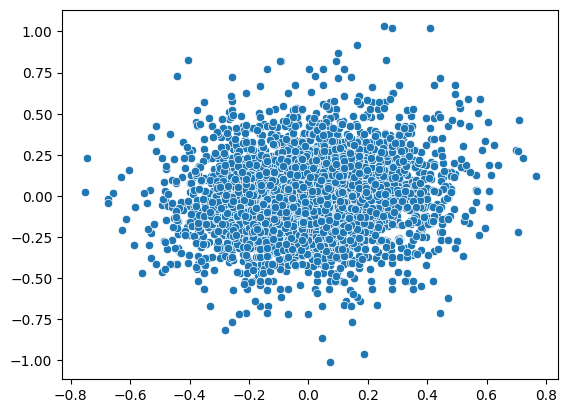

In [83]:
import seaborn as sns

sns.scatterplot(x=subset1['values'].values, y=subset2['values'].values)

In [50]:
train_grp

In [52]:
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        print(f"Time taken by {func.__name__} is {end - start} seconds")
    return wrapper


@timeit
def numpy_dot(a, b):
    return a @ b

@timeit
def cupy_dot(a, b):
    return a @ b

@timeit
def jax_dot(a, b):
    return a @ b

In [54]:
import jax
import jax.numpy as jnp 

# test numpy cupy and jax dot  on a big array
a = np.random.rand(10000, 10000)
b = np.random.rand(10000, 10000)
numpy_dot(a, b)

# a = cp.random.rand(10000, 10000)
# b = cp.random.rand(10000, 10000)
# cupy_dot(a, b)

key = jax.random.PRNGKey(0)
a = jax.random.normal(key, (10000, 10000))
b = jax.random.normal(key, (10000, 10000))
jax_dot(a, b)

Time taken by numpy_dot is 22.937597036361694 seconds


2024-10-04 14:39:48.485138: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Time taken by jax_dot is 0.09475970268249512 seconds


In [226]:
assembly.shape

(148480, 168)

In [206]:
np.median(split_scores, axis=1).mean()

0.8157993788025764

In [207]:
train_values

<xarray.DataArray (presentation: 25)>
array([26, 35, 15, 30,  0, 33,  2, 50,  3, 38, 27, 24,  4, 16, 13, 25, 12,
       19,  8, 10, 17, 23, 14, 22, 42])
Coordinates:
  * presentation  (presentation) MultiIndex
  - repetition    (presentation) int64 26 35 15 30 0 33 2 ... 10 17 23 14 22 42

In [210]:
source_assembly = assembly
target_assembly = train_values
subset_dims = None
dims_must_match = False
repeat = False

In [211]:
subset_dims = subset_dims or target_assembly.dims
subset_dims

('presentation',)

In [212]:
for dim in subset_dims:
    break

In [214]:
assert hasattr(target_assembly, dim)
assert hasattr(source_assembly, dim)
levels = target_assembly[dim].variable.level_names or [dim]
levels

FrozenList(['repetition'])

In [216]:
assert any(hasattr(source_assembly, level) for level in levels)
for level in levels:
    break

In [217]:
target_values = target_assembly[level].values
source_values = source_assembly[level].values

In [237]:
# train

In [239]:
half1 = _average_repetitions(train, split_coord)
half2 = _average_repetitions(test, split_coord)

(3200, 168)

In [199]:
result.raw[0,0:10]

<xarray.DataArray (neuroid: 10)>
array([0.1951266 , 0.6710363 , 0.70019036, 0.20880584, 0.40627083,
       0.52391281, 0.74447828, 0.78908396, 0.79422068, 0.2457201 ])
Coordinates:
    split       int64 0
  * neuroid     (neuroid) MultiIndex
  - neuroid_id  (neuroid) object 'Chabo_L_A_2_4' ... 'Chabo_L_A_4_6'
  - arr         (neuroid) object 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
  - col         (neuroid) int64 4 3 5 0 1 2 3 4 5 6
  - hemisphere  (neuroid) object 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L'
  - subregion   (neuroid) object 'cIT' 'cIT' 'aIT' 'cIT' ... 'cIT' 'aIT' 'aIT'
  - animal      (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Chabo' 'Chabo'
  - y           (neuroid) float64 -1.0 -0.6 -0.6 -0.2 ... -0.2 -0.2 -0.2 -0.2
  - x           (neuroid) float64 -0.2 -0.6 0.2 -1.8 -1.4 -1.0 -0.6 -0.2 0.2 0.6
  - row         (neuroid) int64 2 3 3 4 4 4 4 4 4 4
  - region      (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'

In [192]:
split_score.shape

(168,)

In [179]:
avg_rep_train = average_repetition(train)
avg_rep_test = average_repetition(test)

In [183]:
avg_rep_train.values.shape

(3200, 168)

0.7332874926034039


<Axes: >

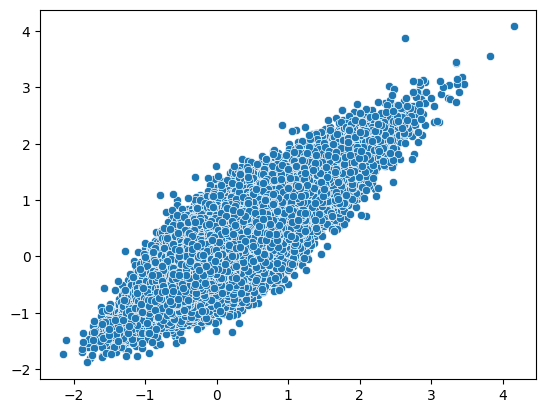

In [187]:
import seaborn as sns
from scipy.stats import pearsonr 

x = avg_rep_train.values.flatten()
y = avg_rep_test.values.flatten()
r = pearsonr(x,y)[0]
print(r)
sns.scatterplot(x=x, y=y)

In [153]:
train_size=0.5,
split_coord = 'repetition'
stratification_coord = None
unique_split_values = True

In [96]:
# then they use this "InternalConsistency" module
# ceiler = load_ceiling('internal_consistency')
# let's break it into it's functional bits

# they are going to call `_consistency(assembly_repetition)`

# consistency_metric = PearsonCorrelation(
#                 stimulus_coord=XarrayDefaults.stimulus_coord, neuroid_dim=XarrayDefaults.neuroid_dim,
#                 neuroid_coord=XarrayDefaults.neuroid_coord)
#             aggregate = consistency_metric.aggregate
    
# _consistency = _SplitHalvesConsistency(consistency_metric=consistency_metric,
#                                                     aggregate=aggregate,
#                                                     split_coord=split_coord)

# It looks like PearsonCorrelation aggregates like this:
# def aggregate(self, scores):
# return scores.median(dim=self._neuroid_dim)

# It looks like _SplitHalvesConsistency call a cross_validation function
# def __call__(self, assembly):
#         return self._cross_validation(assembly, apply=self._consistency, aggregate=self._aggregate)

In [103]:
# class Transformation(object):
#     """
#     Transforms an incoming assembly into parts/combinations thereof,
#     yields them for further processing,
#     and packages the results back together.
#     """

#     def __call__(self, *args, apply, aggregate=None, **kwargs):
#         values = self._run_pipe(*args, apply=apply, **kwargs)

#         score = apply_aggregate(aggregate, values) if aggregate is not None else values
#         score = apply_aggregate(self.aggregate, score)
#         return score

#     def _run_pipe(self, *args, apply, **kwargs):
#         generator = self.pipe(*args, **kwargs)
#         for vals in generator:
#             y = apply(*vals)
#             done = generator.send(y)
#             if done:
#                 break
#         result = next(generator)
#         return result

#     def pipe(self, *args, **kwargs):
#         raise NotImplementedError()

#     def _get_result(self, *args, done):
#         """
#         Yields the `*args` for further processing by coroutines
#         and waits for the result to be sent back.
#         :param args: transformed values
#         :param bool done: whether this is the last transformation and the next `yield` is the combined result
#         :return: the result from processing by the coroutine
#         """
#         result = yield args  # yield the values to coroutine
#         yield done  # wait for coroutine to send back similarity and inform whether result is ready to be returned
#         return result

#     def aggregate(self, score):
#         return Score(score)
    
# class CrossValidationSingle(Transformation):
#     def __init__(self,
#                  splits=Split.Defaults.splits, train_size=None, test_size=None,
#                  split_coord=Split.Defaults.split_coord, stratification_coord=Split.Defaults.stratification_coord,
#                  unique_split_values=Split.Defaults.unique_split_values, random_state=Split.Defaults.random_state):
#         super().__init__()
#         self._split = Split(splits=splits, split_coord=split_coord,
#                             stratification_coord=stratification_coord, unique_split_values=unique_split_values,
#                             train_size=train_size, test_size=test_size, random_state=random_state)
#         self._logger = logging.getLogger(fullname(self))

#     def pipe(self, assembly):
#         """
#         :param assembly: the assembly to cross-validate over
#         """
#         cross_validation_values, splits = self._split.build_splits(assembly)

#         split_scores = []
#         for split_iterator, (train_indices, test_indices), done \
#                 in tqdm(enumerate_done(splits), total=len(splits), desc='cross-validation'):
#             train_values, test_values = cross_validation_values[train_indices], cross_validation_values[test_indices]
#             train = subset(assembly, train_values, dims_must_match=False)
#             test = subset(assembly, test_values, dims_must_match=False)

#             split_score = yield from self._get_result(train, test, done=done)
#             split_score = split_score.expand_dims('split')
#             split_score['split'] = [split_iterator]
#             split_scores.append(split_score)

#         split_scores = Score.merge(*split_scores)
#         yield split_scores

#     def aggregate(self, score):
#         return self._split.aggregate(score)

In [111]:
import xarray as xr
import logging
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedShuffleSplit, ShuffleSplit

def split_data(assembly, 
               splits=10, train_size=None, test_size=None,
               split_coord='stimulus_id', stratification_coord='object_name', 
               kfold=False, unique_split_values=False, random_state=1, 
               preprocess_indices=None):

    # Determine train and test sizes
    if train_size is None and test_size is None:
        train_size = 0.9

    # Choose the split strategy
    if kfold:
        assert (train_size is None or train_size == 0.9) and test_size is None
        if stratification_coord:
            splitter = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)
        else:
            splitter = KFold(n_splits=splits, shuffle=True, random_state=random_state)
    else:
        if stratification_coord:
            splitter = StratifiedShuffleSplit(n_splits=splits, train_size=train_size, test_size=test_size, random_state=random_state)
        else:
            splitter = ShuffleSplit(n_splits=splits, train_size=train_size, test_size=test_size, random_state=random_state)

    # Logging setup
    logger = logging.getLogger(__name__)

    # Extract relevant data
    cross_validation_values, indices = extract_coord(assembly, split_coord, unique=unique_split_values)
    data_shape = np.zeros(len(cross_validation_values))
    args = [assembly[stratification_coord].values[indices]] if stratification_coord else []
    
    # Generate splits
    splits = list(splitter.split(data_shape, *args))
    return cross_validation_values, splits

# Utility function to handle aggregation
def aggregate(values):
    score = apply_aggregate(lambda scores: scores.mean('split'), values)
    score.attrs['error'] = standard_error_of_the_mean(values, 'split')
    return score

In [112]:
def extract_coord(assembly, coord, unique=False):
    if not unique:
        coord_values = assembly[coord].values
        indices = list(range(len(coord_values)))
    else:
        # need unique values for when e.g. repetitions are heavily redundant and splits would yield equal unique values
        coord_values, indices = np.unique(assembly[coord].values, return_index=True)
    dims = assembly[coord].dims
    assert len(dims) == 1
    extracted_assembly = xr.DataArray(coord_values, coords={coord: coord_values}, dims=[coord])
    extracted_assembly = extracted_assembly.stack(**{dims[0]: (coord,)})
    return extracted_assembly if not unique else extracted_assembly, indices

In [113]:
def build_splits
(assembly, split_coord='stimulus_id', stratification_coord='object_name', unique_split_values=False, do_stratify=True):
    cross_validation_values, indices = extract_coord(assembly, split_coord, unique=unique_split_values)
    data_shape = np.zeros(len(cross_validation_values))
    args = [assembly[stratification_coord].values[indices]] if do_stratify else []
    splits = split_data(data_shape, *args)
    return cross_validation_values, list(splits)

In [114]:
stimulus_coord='stimulus_id'
neuroid_dim='neuroid'
neuroid_coord='neuroid_id'

In [133]:
# cross_validation_values, splits = build_splits(assembly_repetition)
split_coord='repetition'
stratification_coord=None
unique_split_values=True
do_stratify=True
assembly = assembly_repetition
cross_validation_values, indices = extract_coord(assembly, split_coord, unique=unique_split_values)

In [134]:
assembly.values.shape, cross_validation_values.shape

((148480, 168), (51,))

In [132]:
_SplitHalvesConsistency.Defaults.split_coord

'repetition'

In [127]:
assembly.values.min(), assembly.values.max()

(-5.8631735, 26.572945)

In [76]:
data = ceiling.raw
data

<xarray.DataArray (split: 10, neuroid: 168)>
array([[0.1951266 , 0.6710363 , 0.70019036, ..., 0.8906245 , 0.82681467,
        0.8486802 ],
       [0.22636659, 0.68390091, 0.71682185, ..., 0.88856218, 0.82896516,
        0.85490966],
       [0.21533617, 0.70659452, 0.70566915, ..., 0.88953989, 0.82539537,
        0.85097236],
       ...,
       [0.18118524, 0.68670523, 0.69847358, ..., 0.89357499, 0.82146316,
        0.85952356],
       [0.24512851, 0.67569792, 0.69308269, ..., 0.89219362, 0.81786032,
        0.85555973],
       [0.19640871, 0.6832725 , 0.70856556, ..., 0.88817281, 0.82258442,
        0.84959486]])
Coordinates:
  * split       (split) int64 0 1 2 3 4 5 6 7 8 9
  * neuroid     (neuroid) MultiIndex
  - neuroid_id  (neuroid) object 'Chabo_L_A_2_4' ... 'Tito_L_M_9_8'
  - arr         (neuroid) object 'A' 'A' 'A' 'A' 'A' 'A' ... 'M' 'M' 'M' 'M' 'M'
  - col         (neuroid) int64 4 3 5 0 1 2 3 4 5 6 2 ... 4 5 6 7 8 1 3 4 5 7 8
  - hemisphere  (neuroid) object 'L' 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion   (neuroid) object 'cIT' 'cIT' 'aIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal      (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y           (neuroid) float64 -1.0 -0.6 -0.6 -0.2 -0.2 ... 1.8 1.8 1.8 1.8
  - x           (neuroid) float64 -0.2 -0.6 0.2 -1.8 -1.4 ... -0.2 0.2 1.0 1.4
  - row         (neuroid) int64 2 3 3 4 4 4 4 4 4 4 5 ... 8 8 8 8 8 9 9 9 9 9 9
  - region      (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT' 'IT'

In [65]:
np.unique(data.neuroid.subregion.values)

array(['aIT', 'cIT', 'pIT'], dtype=object)

In [68]:
subset = data.sel(neuroid=data.neuroid.subregion == 'pIT')
np.mean(subset.values)

0.8316553893043243

In [94]:
# # Select the subset of data where the subregion is 'cIT'
# subset_cIT = ceiling.sel(neuroid=ceiling['subregion'] == 'cIT')
# subset_cIT

# Question 1: What exactly was the Marques2020_Cavanaugh2002-surround_diameter experiment?

https://journals.physiology.org/doi/epdf/10.1152/jn.00692.2001

For all vision experiments, the general experiment is "show animal images" while "recording neural responses". You might also have the animal performing a task (e.g., making a decision about each image), but often for neurophysiology experiments the task is "passive viewing" (stay awake and look at these images).

So, to understand an experiment, you need to ask four sets of questions.

First, you should ask about the "goal" of the experiment
1) What was the goal of the experiment? Usually this can be stated as a question, e.g., "The authors wanted to quantify the size of V1 "classical receptive fields" and the size of the "suppressive surround".

Second, you should ask about the general experiment logic:
1) So how are they going to address this question? e.g., "To address this question, they presented oriented gratings (which elicit strong responses from V1 cells), and varied the size from small to large. They reasoned that responses will increase with size until the "classical receptive field" is filled, and will decrease beyond that size, and should keep decreasing until the "suppressive surround" is filled. (see Figure 1A), and then level off. So by plotting firing rate as a function of stimulus size, and examining the peak and plataues of activation, they could infer the size of the excitatory center and suppressive surround.

Third you should ask about the "stimulus presentation" or "trial design":
1) What was the actual stimulus presentation? (e.g., "The monkey viewed images one at a time, presented for 500ms with a 500ms blank between images.)
2) OK, but how many images? And what did the images look like? How long was a recording session? Did the monkey look at 10000 images straight for 3 hours? 
3) Did the monkey have a task? What was it?
4) What were the "conditions" of the experiment (i.e., what systematic variation was there in the set of images shown)? Note in our example we've somewhat covered this with the "general method" but might be more detailed here...

Fourth, you should ask about the "neural recording":
1) asdf

We recorded the responses of 352 neurons in V1. We onlyincluded neurons in our analysis that ﬁred at least ﬁve spikes/s(334/352 units), and we excluded neurons for which we couldnot determine the CRF boundaries (see following text, 29/334units). Fifty-seven percent of receptive ﬁelds in our samplewere centered within 5° of the fovea, with an additional 9%between 5 and 10°. Eccentricities between 10 and 25° ac-counted for 19% of our data, and the remaining 15% ofreceptive ﬁelds had eccentricities between 25 and 40°. Simpleand complex cells did not respond differently in our experi-ments, and have been pooled for all analyses.



# explore

In [71]:
from brainscore_vision import benchmark_registry
from brainscore_vision import load_dataset, load_metric
from brainscore_vision.metrics.distribution_similarity import NeuronalPropertyCeiling
from brainscore_core.metrics import Metric, Score

In [78]:
ASSEMBLY_NAME = 'Cavanaugh2002a'
# ASSEMBLY_NAME = 'movshon.Cavanaugh2002a'
REGION = 'V1'
TIMEBINS = [(70, 170)]
property_name = 'surround_diameter'
parent = 'V1-surround_modulation'
assembly = load_dataset(ASSEMBLY_NAME)
similarity_metric = load_metric('ks_similarity', property_name=property_name)
ceil_func = NeuronalPropertyCeiling(similarity_metric)
ceil_func

In [66]:
similarity_metric.similarity_func

In [73]:
assembly

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' (neuroid: 190,
                                                   neuronal_property: 5)>
dask.array<open_dataset-55662569f58c9266191bc1b3b2e10bbamovshon.Cavanaugh2002a, shape=(190, 5), dtype=float64, chunksize=(190, 5), chunktype=numpy.ndarray>
Coordinates:
  * neuroid            (neuroid) MultiIndex
  - neuroid_id         (neuroid) int64 0 1 2 3 4 5 6 ... 184 185 186 187 188 189
  - region             (neuroid) object 'V1' 'V1' 'V1' 'V1' ... 'V1' 'V1' 'V1'
  * neuronal_property  (neuronal_property) object 'surround_suppression_index...
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a

In [79]:
assembly.loc[:, property_name].values

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.28597873,  0.36676548,  0.66390666,
        0.54940476,  0.92944661,  0.5185943 ,  0.71201413,  0.7766628 ,
        0.74752449,  0.71554142,  0.55379052,  0.53761666,  0.77009353,
        0.63115032,  0.80516856,  0.72784988,  0.60514681,  0.71898675,
        0.63814255,  0.51241865,  0.72187896,  0.51014274,  1.03000899,
        1.31700738,  1.4014892 ,  1.46329047,  1.41480722,  1.74

In [75]:
assembly.loc[:, property_name].values

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.28597873,  0.36676548,  0.66390666,
        0.54940476,  0.92944661,  0.5185943 ,  0.71201413,  0.7766628 ,
        0.74752449,  0.71554142,  0.55379052,  0.53761666,  0.77009353,
        0.63115032,  0.80516856,  0.72784988,  0.60514681,  0.71898675,
        0.63814255,  0.51241865,  0.72187896,  0.51014274,  1.03000899,
        1.31700738,  1.4014892 ,  1.46329047,  1.41480722,  1.74

In [48]:
model_property = assembly
data_property = assembly
data_property

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' (neuroid: 190,
                                                   neuronal_property: 5)>
dask.array<open_dataset-55662569f58c9266191bc1b3b2e10bbamovshon.Cavanaugh2002a, shape=(190, 5), dtype=float64, chunksize=(190, 5), chunktype=numpy.ndarray>
Coordinates:
  * neuroid            (neuroid) MultiIndex
  - neuroid_id         (neuroid) int64 0 1 2 3 4 5 6 ... 184 185 186 187 188 189
  - region             (neuroid) object 'V1' 'V1' 'V1' 'V1' ... 'V1' 'V1' 'V1'
  * neuronal_property  (neuronal_property) object 'surround_suppression_index...
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a

In [49]:
bins = data_property.attrs[property_name + '_bins']
bins

array([ 0.0625,  0.125 ,  0.25  ,  0.5   ,  1.    ,  2.    ,  4.    ,
        8.    , 16.    ])

In [44]:
# data_property.loc[:, property_name].values

In [50]:
data_property = data_property.loc[:, property_name].values
model_property = model_property.loc[:, property_name].values
data_property

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.28597873,  0.36676548,  0.66390666,
        0.54940476,  0.92944661,  0.5185943 ,  0.71201413,  0.7766628 ,
        0.74752449,  0.71554142,  0.55379052,  0.53761666,  0.77009353,
        0.63115032,  0.80516856,  0.72784988,  0.60514681,  0.71898675,
        0.63814255,  0.51241865,  0.72187896,  0.51014274,  1.03000899,
        1.31700738,  1.4014892 ,  1.46329047,  1.41480722,  1.74

In [51]:
data_property[data_property < bins[0]] = bins[0]
data_property[data_property > bins[-1]] = bins[-1]
model_property[model_property < bins[0]] = bins[0]
model_property[model_property > bins[-1]] = bins[-1]

In [52]:
n_neurons = data_property.shape[0]
n_neurons

190

[ 0.0625  0.125   0.25    0.5     1.      2.      4.      8.     16.    ]
[0.         0.         0.01351351 0.13513514 0.22297297 0.33108108
 0.27027027 0.02702703]


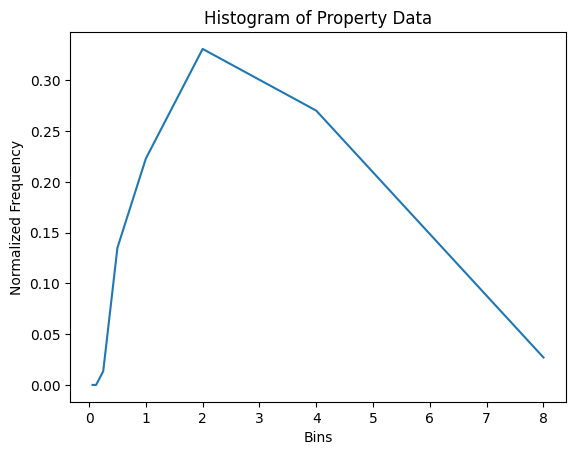

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

data_hist = np.histogram(data_property, bins=bins)[0]
data_hist = data_hist / data_hist.sum()

# sns.lineplot(x=bins, y=data_hist)
print(bins)
print(data_hist)
plt.plot(bins[:-1], data_hist)  # Use bins[:-1] because np.histogram returns one more bin edge than counts
plt.xlabel('Bins')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of Property Data')
plt.show()

In [63]:
# model_property

In [67]:
similarity_func = similarity_metric.similarity_func
NSAMPLES = 1000
ns = NSAMPLES
model_hist = np.zeros((ns, data_hist.shape[0]))
dist_similarity = np.zeros(ns)
for s in range(ns):
    sample = np.random.choice(model_property, n_neurons)
    model_hist[s, :] = np.histogram(sample, bins=bins)[0]
    model_hist[s, :] = model_hist[s, :] / model_hist[s, :].sum()
    dist_similarity[s] = similarity_func(model_hist[s, :], data_hist)
dist_similarity.shape    

(1000,)

In [69]:
if np.isnan(dist_similarity).sum() > NSAMPLES / 10:
    center = 0
    error = 0
else:
    center = np.nanmean(dist_similarity)
    error = np.nanstd(dist_similarity)
center, error

(0.9550782681122956, 0.020910234857298596)

In [72]:
score = Score(center)
score.attrs['error'] = error
score.attrs[Score.RAW_VALUES_KEY] = dist_similarity
score

<xarray.Score ()>
array(0.95507827)
Attributes:
    error:    0.020910234857298596
    raw:      [0.95634096 0.97217806 0.97828829 0.95985692 0.97667531 0.89274...

In [19]:
ceiling = ceil_func(assembly)
ceiling

<xarray.Score ()>
array(0.95412726)
Attributes:
    error:    0.02107994637232268
    raw:      [0.97084413 0.95945946 0.92944475 0.93366093 0.95334825 0.98751...

In [15]:
similarity_metric(assembly, assembly)

<xarray.Score ()>
array(0.95487284)
Attributes:
    error:    0.021795994539370794
    raw:      [0.93607069 0.9286686  0.95773626 0.94408539 0.96414061 0.96740...

In [ ]:
ceiling

# Question 2: What is the structure and content of the neural_data?

Brainscore uses "xarray", which is a way of storing arrays but with additional metadata about dimensions/attributes of the array.

Let's load the data for the surround_diameter

(OK, I don't understand this dataset, skip to Question2B down below).



In [1]:
import os
import time
import brainscore_vision
from brainscore_vision import score
from PIL import Image
import numpy as np

/n/home02/alvarez/.conda/envs/brainscore/lib/python3.11/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [2]:
property_name = 'surround_diameter'
benchmark_identifier=f'Marques2020_Cavanaugh2002-{property_name}'
neural_data = brainscore_vision.load_dataset("Cavanaugh2002a")
neural_data

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' (neuroid: 190,
                                                   neuronal_property: 5)>
dask.array<open_dataset-55662569f58c9266191bc1b3b2e10bbamovshon.Cavanaugh2002a, shape=(190, 5), dtype=float64, chunksize=(190, 5), chunktype=numpy.ndarray>
Coordinates:
  * neuroid            (neuroid) MultiIndex
  - neuroid_id         (neuroid) int64 0 1 2 3 4 5 6 ... 184 185 186 187 188 189
  - region             (neuroid) object 'V1' 'V1' 'V1' 'V1' ... 'V1' 'V1' 'V1'
  * neuronal_property  (neuronal_property) object 'surround_suppression_index...
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a

In [3]:
print(neural_data.dims)
print(neural_data.coords)
print(f"number of neurons: {neural_data.sizes['neuroid_id']}")
# neural_responses = neural_data['neuroid']
# print(neural_responses)

('neuroid', 'neuronal_property')
Coordinates:
  * neuroid            (neuroid) MultiIndex
  - neuroid_id         (neuroid) int64 0 1 2 3 4 5 6 ... 184 185 186 187 188 189
  - region             (neuroid) object 'V1' 'V1' 'V1' 'V1' ... 'V1' 'V1' 'V1'
  * neuronal_property  (neuronal_property) object 'surround_suppression_index...


KeyError: 'neuroid_id'

In [54]:
print(neural_data.data_vars)



AttributeError: 'PropertyAssembly' object has no attribute 'data_vars'

In [47]:
neuroid = 0
neuroid_data = neural_data.sel(neuroid_id=0)
print(neuroid_data)

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    neuroid_id         int64 0
    neuronal_property  <U17 'surround_diameter'
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a


In [53]:
neuroid_data.attrs['surround_suppression_index_bins']

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [43]:
for idx in range(190):
    neuroid_data_array = neural_data.sel(neuroid_id=idx).values
    if ~np.isnan(neuroid_data_array): 
        break
neuroid_data_array

array(0.28597873)

In [44]:
neuroid_data_array

array(0.28597873)

In [46]:
# valid_data = neural_data.dropna(dim='neuroid_id', how='any')
# neuroid_data = valid_data.sel(neuroid_id=0)
# print(neuroid_data)

In [14]:
stimulus_set = neural_data.attrs['stimulus_set']
stimulus_set

,contrast,radius,filename,position_y,orientation,phase,image_id,position_x,spatial_frequency,image_file_name,degrees,stimulus_id
0,1.0,0.105112,0.png,0.5,0.0,0.0,0,0.5,0.771105,dicarlo.Marques2020_size_005050112823.png,12,0
1,1.0,0.105112,1.png,0.5,0.0,45.0,1,0.5,0.771105,dicarlo.Marques2020_size_005050112868.png,12,1
2,1.0,0.105112,2.png,0.5,0.0,90.0,2,0.5,0.771105,dicarlo.Marques2020_size_005050112913.png,12,2
3,1.0,0.105112,3.png,0.5,0.0,135.0,3,0.5,0.771105,dicarlo.Marques2020_size_005050112958.png,12,3
4,1.0,0.105112,4.png,0.5,0.0,180.0,4,0.5,0.771105,dicarlo.Marques2020_size_005050113003.png,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2299,1.0,4.756828,2299.png,0.5,150.0,135.0,2299,0.5,6.168843,dicarlo.Marques2020_size_005054833651.png,12,2299
2300,1.0,4.756828,2300.png,0.5,150.0,180.0,2300,0.5,6.168843,dicarlo.Marques2020_size_005054833696.png,12,2300
2301,1.0,4.756828,2301.png,0.5,150.0,225.0,2301,0.5,6.168843,dicarlo.Marques2020_size_005054833741.png,12,2301
2302,1.0,4.756828,2302.png,0.5,150.0,270.0,2302,0.5,6.168843,dicarlo.Marques2020_size_005054833786.png,12,2302


In [23]:
len(stimulus_set.image_file_name.unique())

2304

In [15]:
df.iloc[0]

contrast                                                   1.0
radius                                                0.105112
filename                                                 0.png
position_y                                                 0.5
orientation                                                0.0
phase                                                      0.0
image_id                                                     0
position_x                                                 0.5
spatial_frequency                                     0.771105
image_file_name      dicarlo.Marques2020_size_005050112823.png
degrees                                                     12
stimulus_id                                                  0
Name: 0, dtype: object

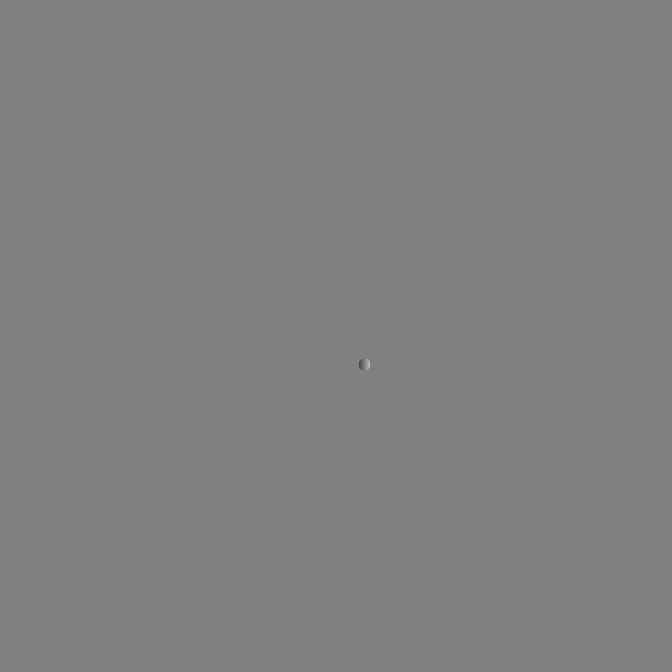

In [19]:
local_path = stimulus_set.get_stimulus(stimulus_set['stimulus_id'].values[0])
Image.open(local_path)

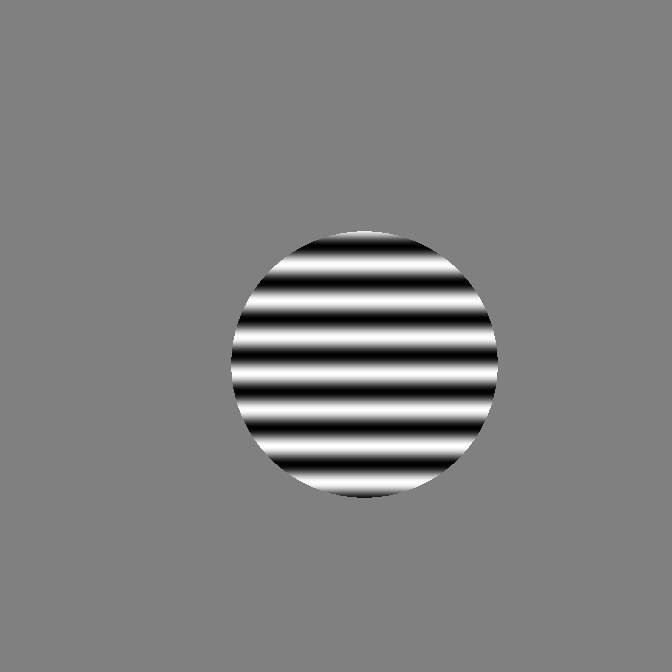

In [21]:
local_path = stimulus_set.get_stimulus(stimulus_set['stimulus_id'].values[1800])
Image.open(local_path)

In [6]:
from brainscore_vision import data_registry

data_registry

{'Cavanaugh2002a': <function brainscore_vision.data.marques2020.<lambda>()>,
 'FreemanZiemba2013_V1_properties': <function brainscore_vision.data.marques2020.<lambda>()>,
 'DeValois1982a': <function brainscore_vision.data.marques2020.<lambda>()>,
 'DeValois1982b': <function brainscore_vision.data.marques2020.<lambda>()>,
 'Ringach2002': <function brainscore_vision.data.marques2020.<lambda>()>,
 'Schiller1976c': <function brainscore_vision.data.marques2020.<lambda>()>}

In [7]:
data = data_registry['Cavanaugh2002a']()
neural_data = data.sel(neuronal_property='surround_diameter', region='V1')
neural_data

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' (neuroid_id: 190)>
dask.array<getitem, shape=(190,), dtype=float64, chunksize=(190,), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id         (neuroid_id) int64 0 1 2 3 4 5 ... 185 186 187 188 189
    neuronal_property  <U17 'surround_diameter'
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a

In [87]:
data = data_registry['Cavanaugh2002a']()
neural_data = data.sel(neuronal_property='surround_diameter', region='V1')
neural_data

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' (neuroid_id: 190)>
dask.array<getitem, shape=(190,), dtype=float64, chunksize=(190,), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id         (neuroid_id) int64 0 1 2 3 4 5 ... 185 186 187 188 189
    neuronal_property  <U17 'surround_diameter'
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a

In [63]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

benchmark_data = neural_data.sel(region='V1')  # (1)
benchmark_data

<xarray.PropertyAssembly 'movshon.Cavanaugh2002a' (neuroid_id: 190,
                                                   neuronal_property: 5)>
dask.array<open_dataset-55662569f58c9266191bc1b3b2e10bbamovshon.Cavanaugh2002a, shape=(190, 5), dtype=float64, chunksize=(190, 5), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id         (neuroid_id) int64 0 1 2 3 4 5 ... 185 186 187 188 189
  * neuronal_property  (neuronal_property) object 'surround_suppression_index...
Attributes:
    number_of_trials:                             20
    surround_suppression_index_bins:              [0.  0.2 0.4 0.6 0.8 1.  1....
    strongly_suppressed_bins:                     [0.  0.5 1. ]
    grating_summation_field_bins:                 [ 0.0625  0.125   0.25    0...
    surround_diameter_bins:                       [ 0.0625  0.125   0.25    0...
    surround_grating_summation_field_ratio_bins:  [ 1  2  4  8 16 32]
    stimulus_set_identifier:                      Marques2020_size
    stimulus_set:                                       contrast    radius  f...
    identifier:                                   movshon.Cavanaugh2002a

In [66]:
average_repetition??

Signature: average_repetition(assembly)
Docstring: <no docstring>
Source:   
def average_repetition(assembly):
    def avg_repr(assembly):
        presentation_coords = [coord for coord, dims, values in walk_coords(assembly)
                               if array_is_element(dims, 'presentation') and coord != 'repetition']
        assembly = assembly.multi_groupby(presentation_coords).mean(dim='presentation', skipna=True)
        return assembly

    return apply_keep_attrs(assembly, avg_repr)
File:      /n/holylabs/LABS/alvarez_lab/Users/alvarez/Projects/vision/brainscore_vision/benchmark_helpers/neural_common.py
Type:      function

In [67]:
benchmark_data.stimulus_set_identifier

'Marques2020_size'